In [ ]:
!pip install -q qiskit
!pip install -q qiskit_aer
!pip install -q pylatexenc
!pip install -q qiskit-ibm-runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 120.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 13.3 MB/s eta 0:00:00


In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
import numpy as np

n=4     QBER(no Eve)= 0.00%   QBER(with Eve)=28.25%
n=8     QBER(no Eve)= 0.00%   QBER(with Eve)=24.47%
n=16    QBER(no Eve)= 0.00%   QBER(with Eve)=25.36%
n=32    QBER(no Eve)= 0.00%   QBER(with Eve)=25.14%
n=64    QBER(no Eve)= 0.00%   QBER(with Eve)=24.30%
n=128   QBER(no Eve)= 0.00%   QBER(with Eve)=24.87%
n=256   QBER(no Eve)= 0.00%   QBER(with Eve)=24.79%
n=512   QBER(no Eve)= 0.00%   QBER(with Eve)=25.18%
n=1024  QBER(no Eve)= 0.00%   QBER(with Eve)=24.81%


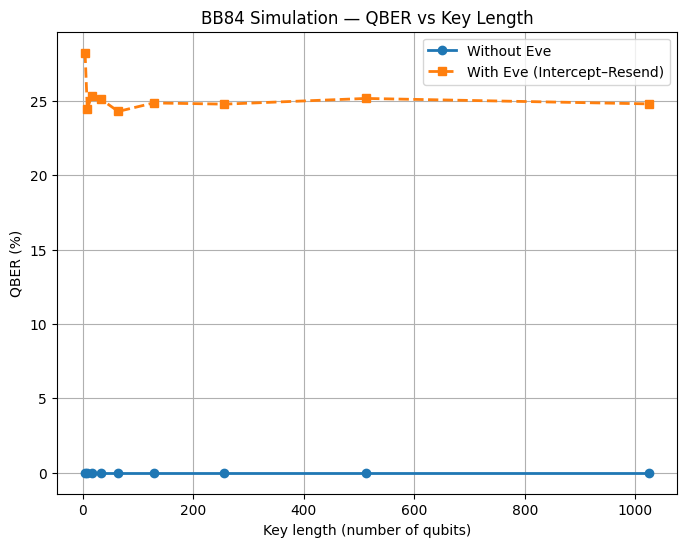

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import Aer
def initialize_circuit_key(key):
    length = len(key)
    qc = QuantumCircuit(length, length)
    for i in range(length):
        if key[i] == 1:
            qc.x(i)
    qc.barrier()
    return qc

def encoder(qc, basis):
    for i, b in enumerate(basis):
        if b == 'X':
            qc.h(i)
    qc.barrier()
    return qc

def decoder(qc, basis):
    for i, b in enumerate(basis):
        if b == 'X':
            qc.h(i)
    return qc


def bb84_qber_once(key_length=8, eve_attack=False):
    key = np.random.choice([0, 1], size=key_length)
    alice_basis = np.random.choice(['Z', 'X'], size=key_length)
    bob_basis = np.random.choice(['Z', 'X'], size=key_length)

    qc = initialize_circuit_key(key)
    qc = encoder(qc, alice_basis)

    if eve_attack:
        eve_basis = np.random.choice(['Z', 'X'], size=key_length)
        qc = decoder(qc, eve_basis)

    qc = decoder(qc, bob_basis)
    qc.measure(range(key_length), range(key_length))

    sim = Aer.get_backend('aer_simulator')
    result = sim.run(qc, shots=1).result()
    counts = result.get_counts()

    measured = np.array([int(i) for i in list(counts.keys())[0][::-1]])

    mask = alice_basis == bob_basis
    alice_sifted = key[mask]
    bob_sifted = measured[mask]

    if len(alice_sifted) > 0:
        qber = np.mean(alice_sifted != bob_sifted)
    else:
        qber = 0.0
    return qber



key_lengths = [4, 8, 16, 32, 64, 128,256, 512,1024]
qbers_no_eve = []
qbers_with_eve = []

trials = 100

for n in key_lengths:
    q_no_eve = np.mean([bb84_qber_once(n, eve_attack=False) for _ in range(trials)])
    q_with_eve = np.mean([bb84_qber_once(n, eve_attack=True) for _ in range(trials)])
    qbers_no_eve.append(q_no_eve)
    qbers_with_eve.append(q_with_eve)
    print(f"n={n:<4}  QBER(no Eve)={q_no_eve*100:5.2f}%   QBER(with Eve)={q_with_eve*100:5.2f}%")



plt.figure(figsize=(8,6))
plt.plot(key_lengths, np.array(qbers_no_eve)*100, 'o-', lw=2, label="Without Eve")
plt.plot(key_lengths, np.array(qbers_with_eve)*100, 's--', lw=2, label="With Eve (Intercept–Resend)")
plt.xlabel("Key length (number of qubits)")
plt.ylabel("QBER (%)")
plt.title("BB84 Simulation — QBER vs Key Length")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)


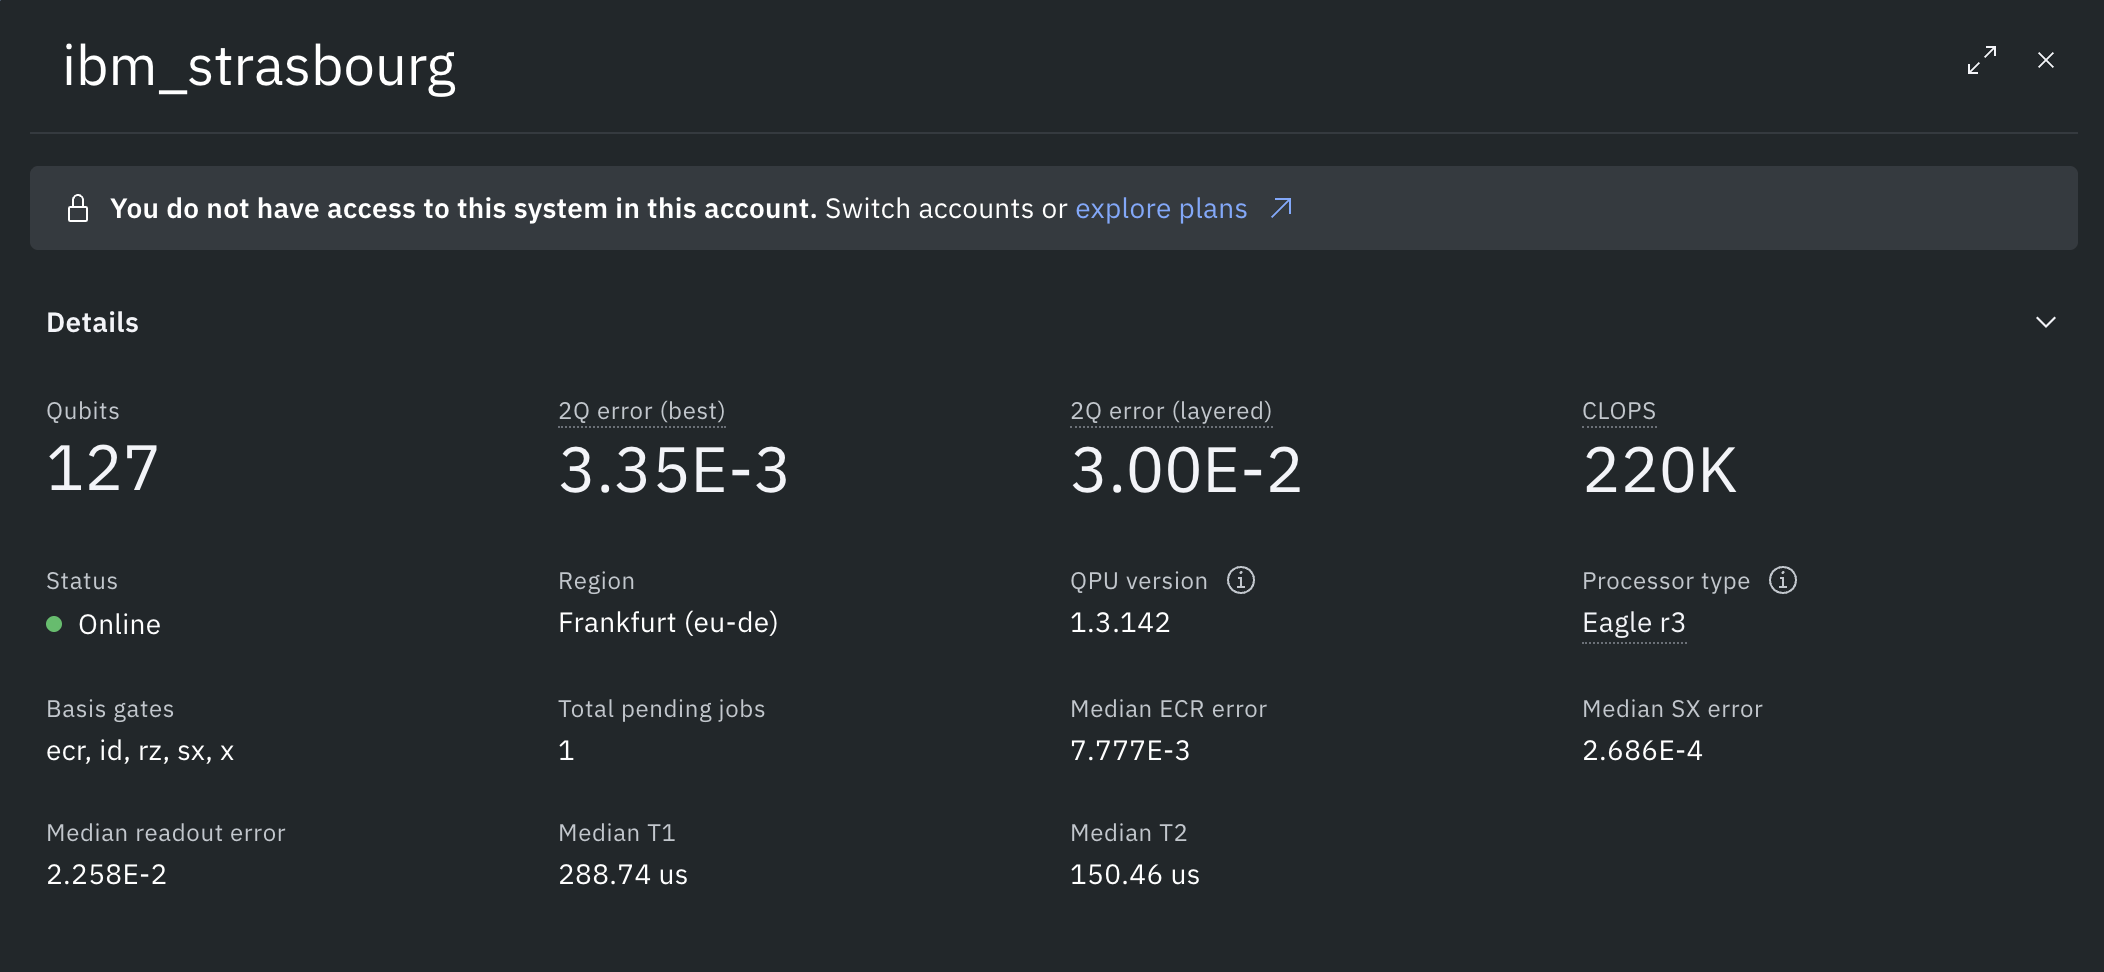

Running BB84 with IBM Strasbourg noise model...
Noise scale 0.20 → QBER (Eve)=0.216, (No Eve)=0.017
Noise scale 0.36 → QBER (Eve)=0.241, (No Eve)=0.000
Noise scale 0.52 → QBER (Eve)=0.228, (No Eve)=0.011
Noise scale 0.68 → QBER (Eve)=0.281, (No Eve)=0.000
Noise scale 0.84 → QBER (Eve)=0.337, (No Eve)=0.008
Noise scale 1.00 → QBER (Eve)=0.246, (No Eve)=0.034


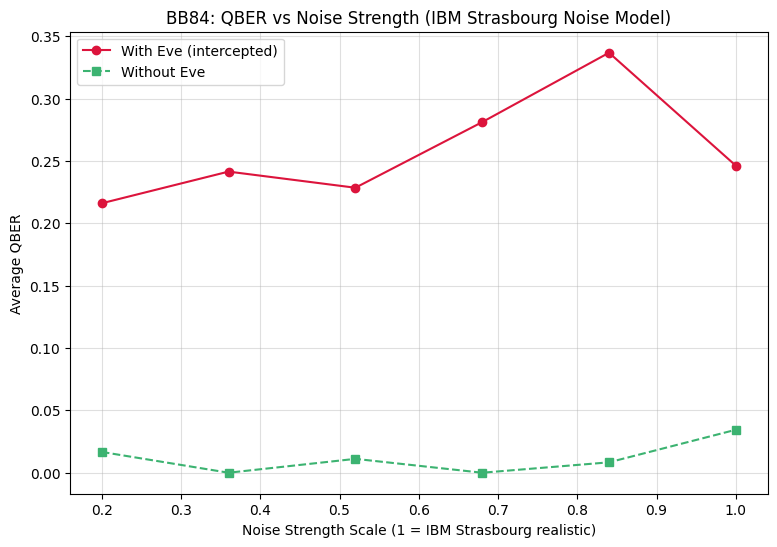

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError


def ibm_strasbourg_noise_model(scale=1.0):
    """Return an Aer noise model that approximates IBM Strasbourg device noise.
       scale < 1 => weaker noise (better fidelity), scale > 1 => stronger noise."""
    noise_model = NoiseModel()


    T1 = 288.74e-6 / scale
    T2 = 150.46e-6 / scale
    gate_time_1q = 50e-9
    gate_time_2q = 300e-9

    p1q = 2.686e-4 * scale
    p2q = 7.777e-3 * scale
    p_readout = 2.258e-2 * scale

    # Errors
    relax_1q = thermal_relaxation_error(T1, T2, gate_time_1q)
    relax_2q = thermal_relaxation_error(T1, T2, gate_time_2q).tensor(
        thermal_relaxation_error(T1, T2, gate_time_2q)
    )
    depol_1q = depolarizing_error(p1q, 1)
    depol_2q = depolarizing_error(p2q, 2)

    combined_1q = relax_1q.compose(depol_1q)
    combined_2q = relax_2q.compose(depol_2q)

    for gate in ["u1", "u2", "u3", "id", "x", "sx", "rz", "h"]:
        noise_model.add_all_qubit_quantum_error(combined_1q, gate)
    noise_model.add_all_qubit_quantum_error(combined_2q, "cx")

    readout = ReadoutError([[1 - p_readout, p_readout],
                            [p_readout, 1 - p_readout]])
    noise_model.add_all_qubit_readout_error(readout)
    return noise_model



def bb84_simulation_realistic(noise_model, key_length=8, num_trials=20, with_eve=True):
    sim = Aer.get_backend('aer_simulator')
    qbers = []
    for _ in range(num_trials):
        key = np.random.choice([0, 1], size=key_length)
        alice_basis = np.random.choice(['Z', 'X'], size=key_length)
        bob_basis = np.random.choice(['Z', 'X'], size=key_length)
        eve_basis = np.random.choice(['Z', 'X'], size=key_length)

        qc = QuantumCircuit(key_length, key_length)
        # Alice encodes
        for i in range(key_length):
            if key[i] == 1:
                qc.x(i)
        qc.barrier()
        for i in range(key_length):
            if alice_basis[i] == 'X':
                qc.h(i)
        qc.barrier()

        if with_eve:
            for i in range(key_length):
                if eve_basis[i] == 'X':
                    qc.h(i)

        for i in range(key_length):
            if bob_basis[i] == 'X':
                qc.h(i)
        qc.measure(range(key_length), range(key_length))

        result = sim.run(qc, noise_model=noise_model, shots=1).result()
        counts = result.get_counts()
        m = list(counts.keys())[0][::-1]
        measured = np.array([int(i) for i in m])

        mask = (alice_basis == bob_basis)
        sift_a = key[mask]
        sift_b = measured[mask]
        qber = np.mean(sift_a != sift_b) if len(sift_a) > 0 else 0
        qbers.append(qber)
    return np.mean(qbers)



noise_strengths = np.linspace(0.2, 1.0, 6)
qber_with_eve, qber_no_eve = [], []

print("Running BB84 with IBM Strasbourg noise model...")
for s in noise_strengths:
    noise = ibm_strasbourg_noise_model(scale=s)
    qber1 = bb84_simulation_realistic(noise, num_trials=30, with_eve=True)
    qber2 = bb84_simulation_realistic(noise, num_trials=30, with_eve=False)
    qber_with_eve.append(qber1)
    qber_no_eve.append(qber2)
    print(f"Noise scale {s:.2f} → QBER (Eve)={qber1:.3f}, (No Eve)={qber2:.3f}")


plt.figure(figsize=(9,6))
plt.plot(noise_strengths, qber_with_eve, 'o-', label='With Eve (intercepted)', color='crimson')
plt.plot(noise_strengths, qber_no_eve, 's--', label='Without Eve', color='mediumseagreen')
plt.xlabel("Noise Strength Scale (1 = IBM Strasbourg realistic)")
plt.ylabel("Average QBER")
plt.title("BB84: QBER vs Noise Strength (IBM Strasbourg Noise Model)")
plt.grid(True, alpha=0.4)
plt.legend()
plt.show()


Running BB84 QBER simulations...

Depolarizing                 | p=0.00 | no Eve=0.000 | with Eve=0.255
Phase Damping                | p=0.00 | no Eve=0.000 | with Eve=0.268
Amplitude Damping            | p=0.00 | no Eve=0.000 | with Eve=0.249
Phase + Amplitude Damping    | p=0.00 | no Eve=0.410 | with Eve=0.445
Pauli                        | p=0.00 | no Eve=0.000 | with Eve=0.247
Depolarizing                 | p=0.07 | no Eve=0.097 | with Eve=0.323
Phase Damping                | p=0.07 | no Eve=0.028 | with Eve=0.282
Amplitude Damping            | p=0.07 | no Eve=0.072 | with Eve=0.312
Phase + Amplitude Damping    | p=0.07 | no Eve=0.424 | with Eve=0.457
Pauli                        | p=0.07 | no Eve=0.087 | with Eve=0.313
Depolarizing                 | p=0.13 | no Eve=0.133 | with Eve=0.312
Phase Damping                | p=0.13 | no Eve=0.076 | with Eve=0.298
Amplitude Damping            | p=0.13 | no Eve=0.158 | with Eve=0.346
Phase + Amplitude Damping    | p=0.13 | no Eve=0.430 | w

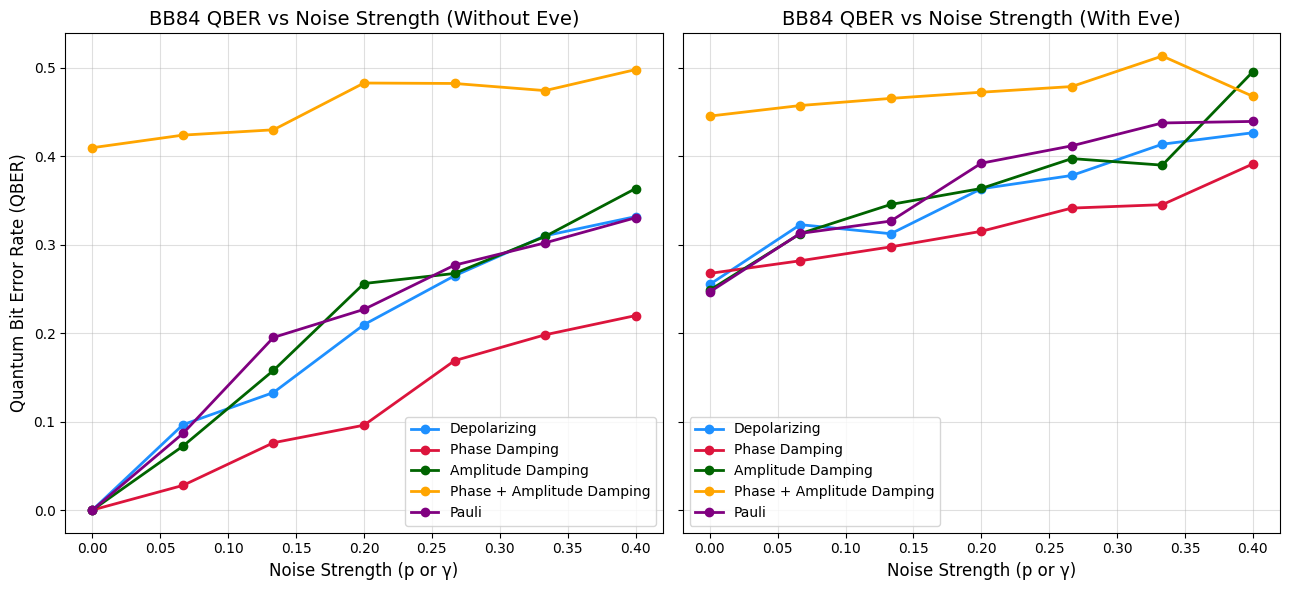

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error
from qiskit_aer.noise.errors import amplitude_damping_error, phase_damping_error, thermal_relaxation_error


def initialize_circuit_key(key):
    qc = QuantumCircuit(len(key), len(key))
    for i, bit in enumerate(key):
        if bit == 1:
            qc.x(i)
    qc.barrier()
    return qc

def encoder(qc, key, basis):
    for i, b in enumerate(basis):
        if b == 'X':
            qc.h(i)
    qc.barrier()
    return qc

def decoder(qc, basis):
    for i, b in enumerate(basis):
        if b == 'X':
            qc.h(i)
    return qc


def create_noise_model(noise_type="none", p=0.05):
    noise_model = NoiseModel()
    if noise_type == "none":
        return noise_model

    if noise_type == "pauli":
        error = pauli_error([('X', p/3), ('Y', p/3), ('Z', p/3), ('I', 1 - p)])
    elif noise_type == "depolarizing":
        error = depolarizing_error(p, 1)
    elif noise_type == "amplitude_damping":
        error = amplitude_damping_error(p)
    elif noise_type == "phase_damping":
        error = phase_damping_error(p)
    elif noise_type == "phase_amplitude_damping":
        T1, T2, gate_time = 100e-6, 80e-6, 100e-6 * (1 + 3 * p)
        error = thermal_relaxation_error(T1, T2, gate_time)
    else:
        raise ValueError("Unknown noise type")

    for g in ['x', 'h', 'id']:
        noise_model.add_all_qubit_quantum_error(error, g)
    readout_error = pauli_error([('X', p / 2), ('I', 1 - p / 2)])
    noise_model.add_all_qubit_quantum_error(readout_error, 'measure')

    return noise_model


def bb84_simulation(noise_type="none", p=0.0, key_length=16, num_trials=100, with_eve=True):
    sim = Aer.get_backend('aer_simulator')
    noise_model = create_noise_model(noise_type, p)
    qbers = []

    for _ in range(num_trials):
        key = np.random.choice([0, 1], size=key_length)
        alice_basis = np.random.choice(['Z', 'X'], size=key_length)
        bob_basis = np.random.choice(['Z', 'X'], size=key_length)
        eve_basis = np.random.choice(['Z', 'X'], size=key_length)

        qc = initialize_circuit_key(key)
        qc = encoder(qc, key, alice_basis)
        if with_eve:
            qc = decoder(qc, eve_basis)
        qc = decoder(qc, bob_basis)
        qc.measure(range(key_length), range(key_length))

        compiled = transpile(qc, sim)
        result = sim.run(compiled, noise_model=noise_model, shots=1).result()
        counts = result.get_counts()
        measured = np.array([int(i) for i in list(counts.keys())[0][::-1]])

        mask = (alice_basis == bob_basis)
        sift_a = key[mask]
        sift_b = measured[mask]
        qber = np.mean(sift_a != sift_b) if len(sift_a) > 0 else 0
        qbers.append(qber)

    return np.mean(qbers)

noise_types = {
    "Depolarizing": "depolarizing",
    "Phase Damping": "phase_damping",
    "Amplitude Damping": "amplitude_damping",
    "Phase + Amplitude Damping": "phase_amplitude_damping",
    "Pauli": "pauli"
}

noise_strengths = np.linspace(0.0, 0.4, 7)
results_with_eve = {label: [] for label in noise_types}
results_without_eve = {label: [] for label in noise_types}

print("Running BB84 QBER simulations...\n")

for p in noise_strengths:
    for label, ntype in noise_types.items():
        qber_no_eve = bb84_simulation(ntype, p, key_length=16, num_trials=100, with_eve=False)
        qber_with_eve = bb84_simulation(ntype, p, key_length=16, num_trials=100, with_eve=True)
        results_without_eve[label].append(qber_no_eve)
        results_with_eve[label].append(qber_with_eve)
        print(f"{label:28s} | p={p:.2f} | no Eve={qber_no_eve:.3f} | with Eve={qber_with_eve:.3f}")


fig, axs = plt.subplots(1, 2, figsize=(13, 6), sharey=True)
colors = ['dodgerblue', 'crimson', 'darkgreen', 'orange', 'purple']


for (label, qbers), c in zip(results_without_eve.items(), colors):
    axs[0].plot(noise_strengths, qbers, 'o-', lw=2, color=c, label=label)
axs[0].set_title("BB84 QBER vs Noise Strength (Without Eve)", fontsize=14)
axs[0].set_xlabel("Noise Strength (p or γ)", fontsize=12)
axs[0].set_ylabel("Quantum Bit Error Rate (QBER)", fontsize=12)
axs[0].grid(alpha=0.4)
axs[0].legend(fontsize=10)


for (label, qbers), c in zip(results_with_eve.items(), colors):
    axs[1].plot(noise_strengths, qbers, 'o-', lw=2, color=c, label=label)
axs[1].set_title("BB84 QBER vs Noise Strength (With Eve)", fontsize=14)
axs[1].set_xlabel("Noise Strength (p or γ)", fontsize=12)
axs[1].grid(alpha=0.4)
axs[1].legend(fontsize=10)

plt.tight_layout()
plt.show()
